# Baseline model

The first step is to load the data extracted from our transactional data (warehouse)
The queries used are saved in this repo for documentation purposes.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data
cart_items = pd.read_csv('data_git/cart_items.csv')


A bit about how the data is structured at Metaloop. We essentially have these sources of trasactional material data:

 - Cart items
    - These are the materials that compose a transaction (stored in the orders object). Each order is associated with two accounts, a seller and a buyer. Therefore, the lowest granularity data here will be cart item level data with data from the orders joined
 - Opportunity materials
    - These play a similar role as cart items, but on the opportunity level (prior to an order being put forward)
   
 - Conditions (Contract materials)

For the purpose of this baseline model, we will use only cart items data, which is our most comprehensive database.
 

## Simple bag of words model

With a simple bag of words model, we try to extract features from the alias, material and formula fields. Our target variable is the variable product_id, which is a class corresponding to the underlying product related to the material. This is encoded by the class in the `fk_material` column.

### The training of an NLP model

1. Preprocessing the text
2. Vectozing the text
3. Choose appropriate ML model to train

In [9]:
# Change ds_material_alias to string
cart_items['ds_material_alias'] = cart_items['ds_material_alias'].astype(str)

Next, we define functions to extract metadata about the text of the alias names

In [10]:
# Define function to count words
def count_words(string):
    return len(string.split())

# Define function to get the average word length
def avg_word_length(string):
    words = string.split()
    return sum(len(word) for word in words) / len(words)

# Check if the description has the percentage symbol
cart_items['flg_has_perc'] = cart_items['ds_material_alias'].apply(lambda x: len([c for c in x if c == '%'])>0)

# Create number of words for the two columns available
cart_items['n_words_alias'] = cart_items['ds_material_alias'].apply(count_words)

# Inspect results
cart_items.head()


,ds_sale_price_formula,ds_purchase_price_formula,ds_material_alias,vl_quantity_sell,vl_unit_price_sell,fk_material,cd_alias_language,cd_product_id,lower(ds_category_en),lower(ds_record_type_name),flg_has_perc,n_words_alias
0,NaN,NaN,Kupfer Raff Granulat,2163.0,6.10000,a0Z09000000H7jvEAC,de,60001.0,copper,wholesale - europe domestic,False,3
1,NaN,NaN,"Kupfer-Nickel, blank",17500.0,13.18583,a0Z09000005Ecu7EAC,de,600041.0,copper,wholesale - europe domestic,False,2
2,NaN,NaN,"Edelstahl, V2A, Nirosta, Niro",14560.0,2.01000,a0Z09000000oVRUEA2,de,18037.0,stainless steel,wholesale - europe domestic,False,4
3,NaN,NaN,"Edelstahl, V2A, Nirosta, Niro",1484.0,2.06000,a0Z09000000oVRUEA2,de,18037.0,stainless steel,wholesale - europe domestic,False,4
4,NaN,NaN,"Edelstahl, V4A Schrott",5980.0,2.80000,a0Z09000000oVWZEA2,de,18039.0,stainless steel,wholesale - europe domestic,False,3


In [11]:
# converting the data to lower case
cart_items['ds_material_alias'] = cart_items['ds_material_alias'].str.lower()

# Removing the leading and trailing whitespaces
cart_items['ds_material_alias'] = cart_items['ds_material_alias'].str.strip()

## Formula parsing


In [12]:
avg_1 = np.mean(cart_items['ds_sale_price_formula'].isna())

avg_2 = np.mean(cart_items['ds_purchase_price_formula'] == 'nan')

print(
    """
    avg_1: {}
    avg_2: {}""".format(avg_1, avg_2)
)


    avg_1: 0.9882225823878984
    avg_2: 0.0


In [13]:
import sys

module_path = 'models'
sys.path.append(module_path)

# Import the functions from the python file
import formula_parsing_function as fpf

# Apply the functions to the column

# Change formula type to
cart_items['ds_sale_price_formula'] = cart_items['ds_sale_price_formula'].astype(str)

# Detect currency
cart_items['currency'] = cart_items['ds_sale_price_formula'].apply(fpf.detect_currency)

# Get operator
cart_items['operator'] = cart_items['ds_sale_price_formula'].apply(fpf.detect_operator)

# Get index
cart_items['index'] = cart_items['ds_sale_price_formula'].apply(fpf.detect_index)

# Get constant
cart_items['constant'] = cart_items['ds_sale_price_formula'].apply(fpf.detect_constant)

# Convert to float
cart_items['constant'] = cart_items['constant'].apply(fpf.convert_constant)

# Get unit
cart_items['unit'] = cart_items['ds_sale_price_formula'].apply(fpf.detect_unit)

# Identify if the price is fixed
cart_items['fixed_price'] = cart_items['ds_sale_price_formula'].str.contains('fix')

### End of preprocessing
----

### Vectorization

Now that we have done the pre-processing of the text, we can work on vectorizing it. We will apply three simple methods to arrive at the baseline for the feature extraction of the text.

## Training

We will start now training the baseline model

Mean Squared Error:  2510.5942018141395


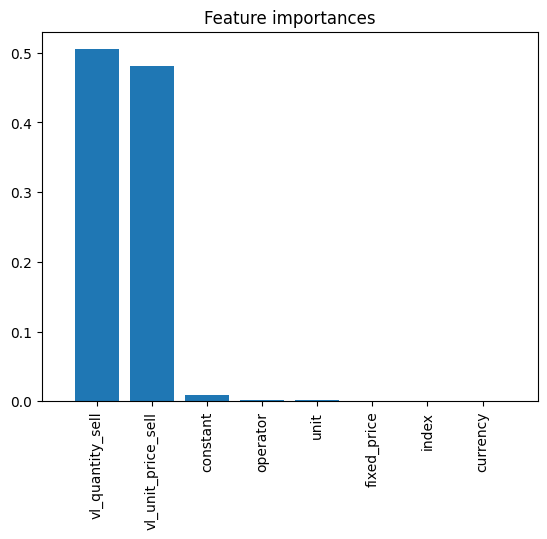

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Your original features and categorical feature indices
features = [
    'vl_quantity_sell', 'vl_unit_price_sell', 'currency', 'operator', 'index',
    'constant', 'unit', 'fixed_price'
]

categorical_features = [2, 3, 4, 6]  # Column indices of categorical features

label = ['fk_material']

# For categorical features, we can fill missing values with 'missing'
cart_items[['currency', 'operator', 'index', 'unit']] = cart_items[['currency', 'operator', 'index', 'unit']].fillna('missing')

# For numerical features, we can fill missing values with a statistic (here, I'm using zero)
cart_items[['vl_quantity_sell', 'vl_unit_price_sell', 'constant']] = cart_items[['vl_quantity_sell', 'vl_unit_price_sell', 'constant']].fillna(0)

# Declare the features and the label
X = cart_items[features].to_numpy()
y = cart_items[label].to_numpy()

# Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Encode the categorical features using OrdinalEncoder
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Fit and transform the training data
X_train[:, categorical_features] = oe.fit_transform(X_train[:, categorical_features])

# Transform the testing data
X_test[:, categorical_features] = oe.transform(X_test[:, categorical_features])

# Fit and transform the tagets
y_train = oe.fit_transform(y_train)
y_test = oe.transform(y_test)

# Import the model and instantiate it
rf = RandomForestRegressor()

# Fit the model
rf.fit(X_train, y_train.ravel())  # Flatten y_train since it has the shape (n_samples, 1)

# Predict the model
y_pred = rf.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)

print("Mean Squared Error: ", mse)

# Plot feature importance
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), np.array(features)[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()